In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')  # a good general style


In [2]:
# Load the dataset
df = pd.read_csv('DOGE-USD.csv')  # Adjust path if needed

# Show dimensions and first few rows
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (1723, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


In [3]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Check column data types
print("\nData types:\n", df.dtypes)


Missing values in each column:
 Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Data types:
 Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [4]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Confirm the data is clean
print("Missing values after cleaning:\n", df.isnull().sum())
df.head()


Missing values after cleaning:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


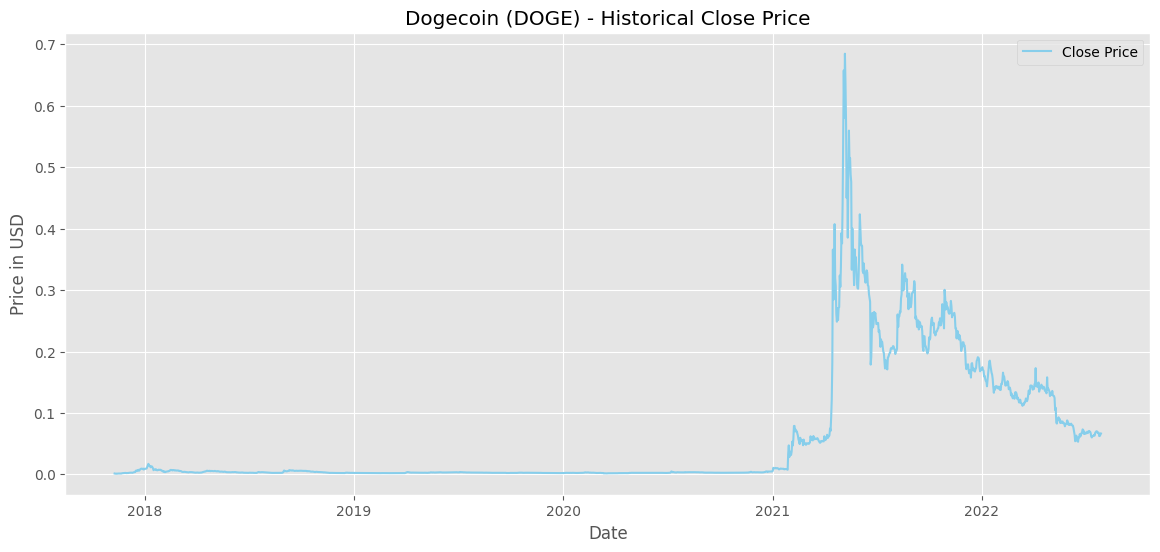

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price', color='skyblue')
plt.title('Dogecoin (DOGE) - Historical Close Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' column for prediction
close_data = df[['Close']]

# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Display shape
print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (1722, 1)


In [7]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Use 60 past time steps to predict the next
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

print("Input shape (X):", X.shape)  # (samples, 60, 1)
print("Target shape (y):", y.shape)


Input shape (X): (1662, 60, 1)
Target shape (y): (1662, 1)


In [8]:
# Reshape input to fit LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))
print("Reshaped X shape:", X.shape)


Reshaped X shape: (1662, 60, 1)


In [9]:
# Split into training and testing sets (e.g., 80% train)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 1329
Testing samples: 333


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


c:\Users\srini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,           # You can increase this later
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0055 - val_loss: 6.0660e-04
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0020 - val_loss: 6.4328e-04
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0016 - val_loss: 7.2747e-04
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0013 - val_loss: 4.3321e-04
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013 - val_loss: 4.0394e-04
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 4.9156e-04
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017 - val_loss: 3.4793e-04
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.7516e-04 - val_loss: 0.0016
Epoch 12/20
42/42 ━━━━━━━━━━━━━

In [12]:
# Predict on test data
predicted_price = model.predict(X_test)

# Undo scaling to get real price values
predicted_price = scaler.inverse_transform(predicted_price)
actual_price = scaler.inverse_transform(y_test.reshape(-1, 1))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


In [16]:
# Convert to 1D arrays if needed
actual_price = actual_price.flatten()
predicted_price = predicted_price.flatten()

# Calculate scores
mae = mean_absolute_error(actual_price, predicted_price)
mse = mean_squared_error(actual_price, predicted_price)
rmse = np.sqrt(mse)
r2 = r2_score(actual_price, predicted_price)

# Print scores
print(f" Mean Absolute Error (MAE): {mae:.6f}")
print(f" Mean Squared Error (MSE): {mse:.6f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f" R² Score: {r2:.6f}")


 Mean Absolute Error (MAE): 0.008470
 Mean Squared Error (MSE): 0.000148
 Root Mean Squared Error (RMSE): 0.012160
 R² Score: 0.966189


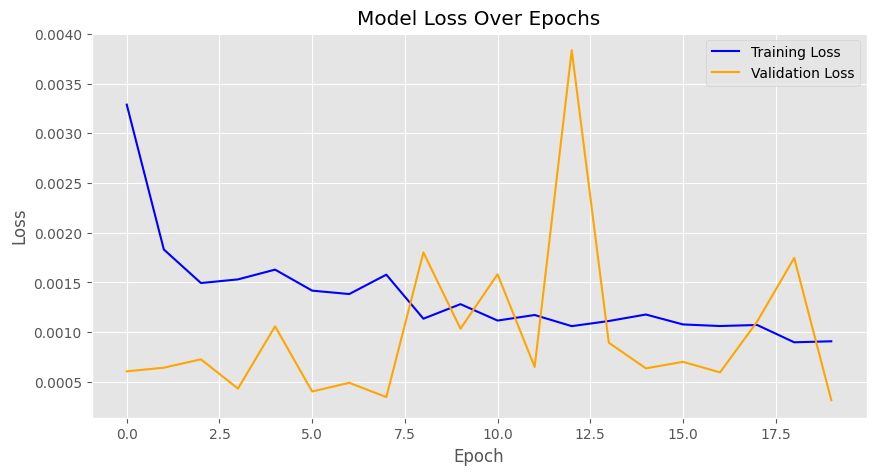

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()


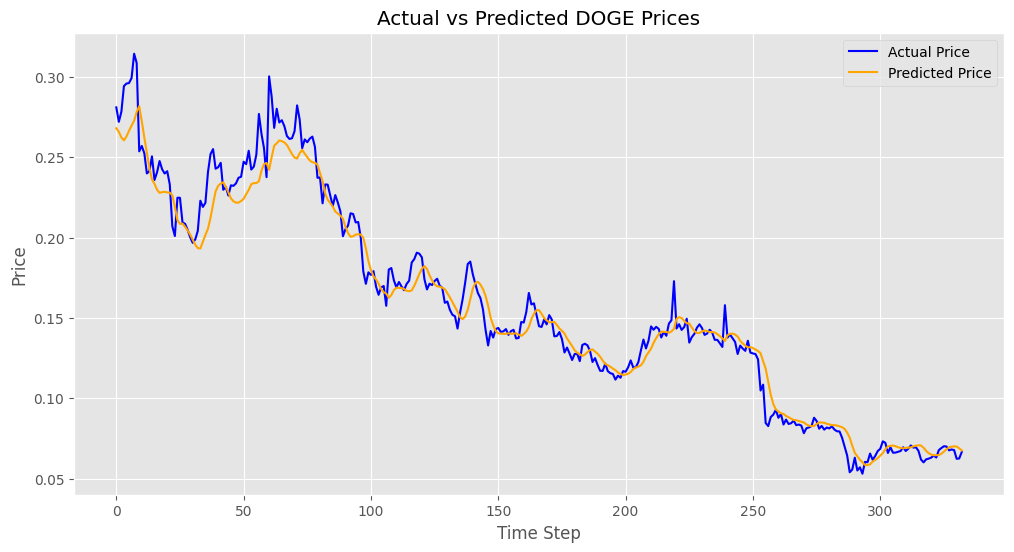

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(actual_price, label='Actual Price', color='blue')
plt.plot(predicted_price, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted DOGE Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


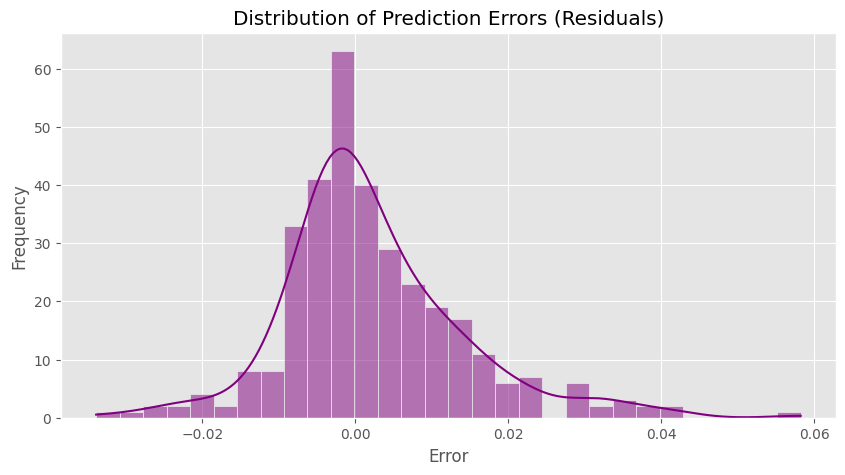

In [19]:
import seaborn as sns

residuals = actual_price - predicted_price

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)

# Save the plot
plt.savefig('residuals_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


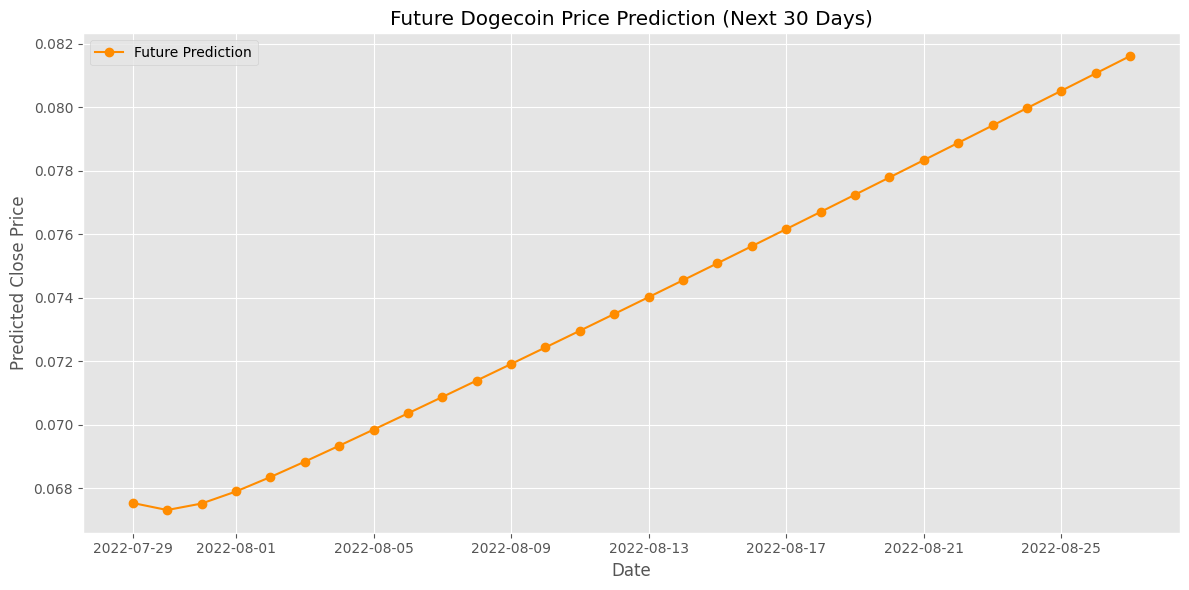

In [27]:
# Use the correct DataFrame for date
try:
    last_date = df['Date'].iloc[-1]
except KeyError:
    # Try index instead, if Date is not a column
    last_date = df.index[-1]

# Future prediction (same as before)
future_days = 30
last_sequence = X_test[-1]
future_predictions = []
current_sequence = last_sequence.copy()

for _ in range(future_days):
    pred = model.predict(current_sequence.reshape(1, 60, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    current_sequence = np.append(current_sequence[1:], pred[0, 0]).reshape(60, 1)

# Inverse transform
future_predictions_scaled = np.array(future_predictions).reshape(-1, 1)
future_predictions_actual = scaler.inverse_transform(
    np.concatenate((future_predictions_scaled, np.zeros_like(future_predictions_scaled)), axis=1)
)[:, 0]

# Generate future dates
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.Timedelta(days=1), periods=future_days)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_actual, marker='o', linestyle='-', color='darkorange', label='Future Prediction')
plt.title('Future Dogecoin Price Prediction (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('future_price_prediction.png')
plt.show()


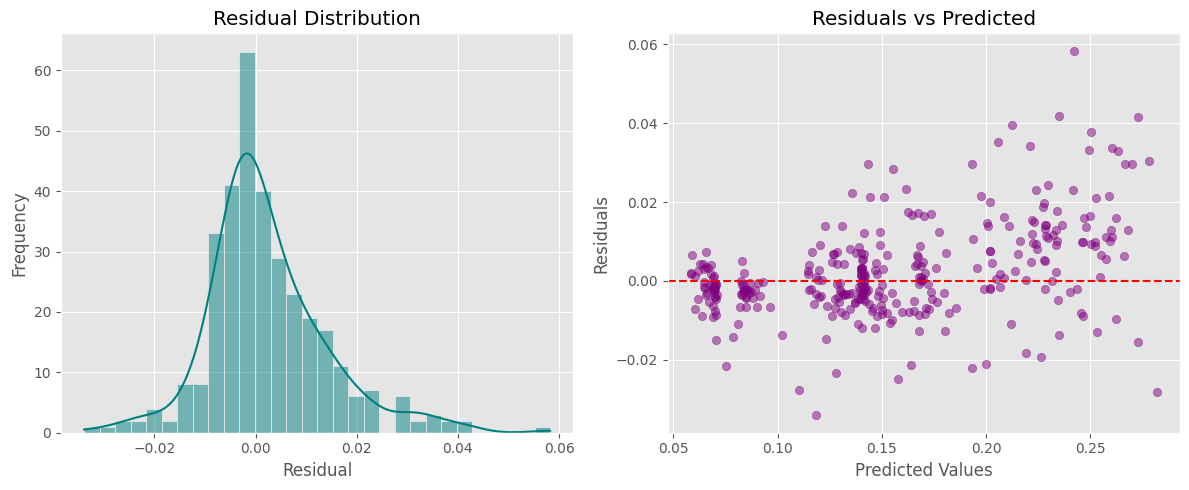

In [28]:
# Residuals = actual - predicted
residuals = y_test_actual - y_pred_actual

plt.figure(figsize=(12, 5))

# Histogram of residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# Residuals vs Predictions scatter
plt.subplot(1, 2, 2)
plt.scatter(y_pred_actual, residuals, color='purple', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.savefig("residual_diagnostics.png")
plt.show()


In [29]:
# Displaying strategic model improvement ideas
improvement_ideas = {
    "Model Tuning": [
        "Increase LSTM units or add more LSTM layers (with care).",
        "Tune dropout rates to prevent overfitting.",
        "Try Bidirectional LSTM for better context understanding.",
        "Experiment with different optimizers (e.g., RMSprop, AdamW)."
    ],
    "Feature Engineering": [
        "Add technical indicators: RSI, MACD, Bollinger Bands, etc.",
        "Include volume and volatility features.",
        "Use lagged features: previous close, previous 5-day average, etc.",
        "Incorporate calendar features: day of week, month, quarter."
    ],
    "Data Augmentation": [
        "Use sliding windows with overlaps to create more training sequences.",
        "Use synthetic data generation (like SMOTE or GANs for time series)."
    ],
    "Model Alternatives": [
        "Try GRU (Gated Recurrent Units) or Transformer models.",
        "Combine LSTM with CNN layers (CNN-LSTM hybrid).",
        "Use traditional ML models like XGBoost as baselines."
    ],
    "Post-Processing": [
        "Use ensemble of multiple LSTM models.",
        "Apply smoothing techniques on predictions (e.g., EMA).",
        "Forecast prediction intervals (quantile regression)."
    ]
}

# Print neatly
from pprint import pprint
pprint(improvement_ideas)


{'Data Augmentation': ['Use sliding windows with overlaps to create more '
                       'training sequences.',
                       'Use synthetic data generation (like SMOTE or GANs for '
                       'time series).'],
 'Feature Engineering': ['Add technical indicators: RSI, MACD, Bollinger '
                         'Bands, etc.',
                         'Include volume and volatility features.',
                         'Use lagged features: previous close, previous 5-day '
                         'average, etc.',
                         'Incorporate calendar features: day of week, month, '
                         'quarter.'],
 'Model Alternatives': ['Try GRU (Gated Recurrent Units) or Transformer '
                        'models.',
                        'Combine LSTM with CNN layers (CNN-LSTM hybrid).',
                        'Use traditional ML models like XGBoost as baselines.'],
 'Model Tuning': ['Increase LSTM units or add more LSTM layers (with ca

In [31]:
# Save in the recommended Keras format
model.save("lstm_stock_model.keras")
joblib.dump(scaler, "scaler.save")

print("✅ Model (Keras format) and scaler saved successfully.")


✅ Model (Keras format) and scaler saved successfully.


In [32]:
# Load the model and scaler
loaded_model = load_model("lstm_stock_model.keras")
loaded_scaler = joblib.load("scaler.save")

print("✅ Keras model and scaler loaded.")


✅ Keras model and scaler loaded.


c:\Users\srini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
